In [23]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [24]:
# Let us create three datasets. The first is a toy one, the second consists
# of blobs of points, and the second consists of concentric circles.

blob = lambda x, y, stddev, n_samples: list(zip(
    np.random.normal(x, stddev, n_samples),
    np.random.normal(y, stddev, n_samples)
))

circle = lambda x, y, stddev, radius, n_samples: [
    (
        x + radius * math.cos(2 * math.pi * i / n_samples) + np.random.normal(0, stddev),
        y + radius * math.sin(2 * math.pi * i / n_samples) + np.random.normal(0, stddev)
    )
    for i in range(n_samples)
]

In [25]:
birthday_dataset = [(0, 0), (0, 10), (10, 0), (10, 10), (420, 420), (420, 430), (430, 420), (430, 430)]
plt.scatter(*zip(*birthday_dataset), s=10, color='black')
plt.show()

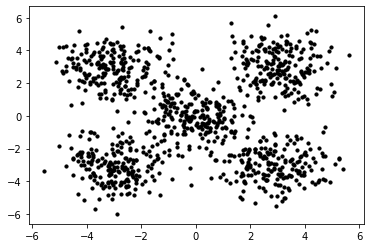

In [26]:
blobs_dataset = sum((blob(x, y, 1, 200) for x, y in [(0, 0), (3, 3), (-3, 3), (-3, -3), (3, -3)]), start=[])
plt.scatter(*zip(*blobs_dataset), s=10, color='black')
plt.show()

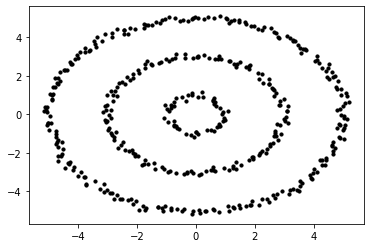

In [27]:
circles_dataset = sum((circle(0, 0, 0.1, radius, radius * 50) for radius in [1, 3, 5]), start=[])
plt.scatter(*zip(*circles_dataset), s=10, color='black')
plt.show()

In [28]:
def display_clusters(clusters):
    # get len(clusters) spaced out colors
    colors = plt.get_cmap('Accent')(np.linspace(0, 1, len(clusters)))
    for (cluster_center, cluster), color in zip(clusters.items(), colors):
        # plot the cluster center using a bigger marker
        plt.scatter(*cluster_center, s=1000, color=color, alpha=0.2)
        # plot the cluster points using small markers
        plt.scatter(*zip(*cluster), s=10, color=color)
    plt.show()

def compute_clusters(X, cluster_centers):
    '''
    Given fixed cluster centers, computes the clusters of each cluster center c
    with respect to X, i.e. the set of points whose nearest cluster center is c.
    
    Returns:
        clusters (dict): the clusters as sets of points (tuples of floats),
            keyed by their cluster center
    '''
    # shapes: X (nxd),  c_c (cxd)
    X, cluster_centers = np.array(X), np.array(cluster_centers)
    # TODO: Implement this, and use the following two cells to ensure it works.
    # We will probably do this together because numpy is hard.
    
    #cluster_centers[:, np.new_axis, :] # keeps everything but adds new dim in the middle, shape: cx1xd
    diff = X - np.repeat(cluster_centers[:, np.newaxis, :], len(X), axis = 1) 
    # shape: cxnxd, pairwise vec diffs
    
    norms = np.linalg.norm(diff, axis = 2) # shape cxn 
    
    # now we want argmin
    closest_cc = cluster_centers[np.argmin(norms, axis = 0)] # shape n,
    clusters = defaultdict(set) # converts into a set
    for (x,cluster_centers) in zip(X, closest_cc):
        clusters[tuple(cluster_centers)].add(tuple(x))
    return dict(clusters)

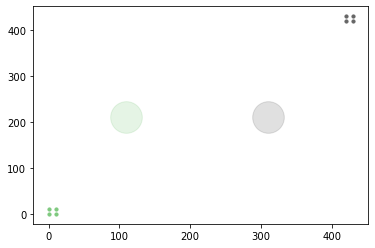

In [29]:
# The bottom-left points should be green, and the top-right points should be gray
display_clusters(compute_clusters(birthday_dataset, [(110, 210), (310, 210)]))

In [30]:
# Here are some tests for `compute_clusters`
assert compute_clusters(birthday_dataset, [(5, 5), (425, 425)]) == {
    (5, 5): {(0, 0), (0, 10), (10, 0), (10, 10)},
    (425, 425): {(420, 420), (420, 430), (430, 420), (430, 430)}
}
assert compute_clusters(birthday_dataset, [(210, 210)]) == {
    (210, 210): set(birthday_dataset)
}
assert compute_clusters(birthday_dataset, birthday_dataset) == {
    point: {point}
    for point in birthday_dataset
}
assert compute_clusters(birthday_dataset, [(110, 210), (310, 210)]) == {
    (110, 210): {(0, 0), (0, 10), (10, 0), (10, 10)},
    (310, 210): {(420, 420), (420, 430), (430, 420), (430, 430)}
}

In [31]:
# TODO: Make a `KMeans` class that implements the KMeans algorithm and passes
#    the tests in the following cell. In particular, your implementation
#    should basically live in the `__init__` method and should store the
#    results in `converged` and `clusters` attributes.

In [32]:
class myKMeans:
    # X <- data set
    # K <- num of clusters
    # max_iter <- max iterations to find centers

    def __init__(self, X, K, max_iter = 300):
        #self.converged <- boolean val
        self.X = X
        self.K = K
        self.cluster_centers = random.sample(X, k = K)
        self.max_iter = max_iter
        self.converged = False
        
        for i in range(self.max_iter):
            new_cluster_centers = [tuple(np.mean(list(cluster), axis = 0)) 
                                   for cluster in self.clusters.values()]
            # checking if old centers same as new
            if set(self.cluster_centers) == set(new_cluster_centers):
                self.converged = True
                break
            #otherwise, update centers
            self.cluster_centers = new_cluster_centers
    
    @property 
    def clusters(self):  
        return compute_clusters(self.X, self.cluster_centers)

birthday_dataset clusters

In [33]:
kmeans_birthday = myKMeans(birthday_dataset, 2)

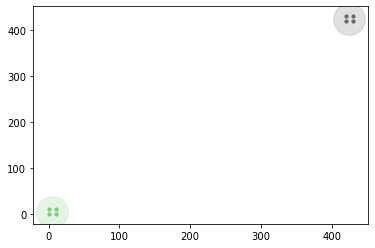

In [34]:
display_clusters(compute_clusters(birthday_dataset, kmeans_birthday.cluster_centers))

In [35]:
# Here are some tests for the KMeans class
kmeans_birthday = myKMeans(birthday_dataset, 2)

assert kmeans_birthday.converged
assert kmeans_birthday.clusters == {
    (5, 5): {(0, 0), (0, 10), (10, 0), (10, 10)},
    (425, 425): {(420, 420), (420, 430), (430, 420), (430, 430)}
}

kmeans_one_iteration = myKMeans(blobs_dataset, 5, max_iter=1)
assert not kmeans_one_iteration.converged

blobs_dataset clusters

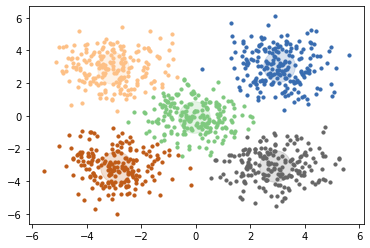

In [36]:
kmeans_blobs = myKMeans(blobs_dataset, 5)
display_clusters(kmeans_blobs.clusters)

circles_dataset clusters

kmeans_circles.converged=True


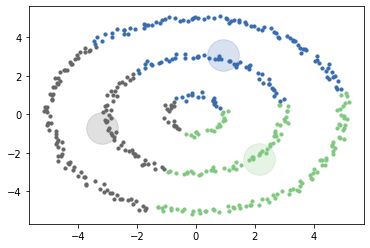

In [37]:
kmeans_circles = myKMeans(circles_dataset, 3)
print(f'{kmeans_circles.converged=}')
display_clusters(kmeans_circles.clusters)

###  1. How does the execution speed compare to the implementation in the library sklearn?

In [38]:
from sklearn.cluster import KMeans

%timeit myKMeans(birthday_dataset, 2)
%timeit KMeans(n_clusters = 2).fit(birthday_dataset)

214 µs ± 4.75 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
16.1 ms ± 2.56 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
%timeit myKMeans(circles_dataset, 3)
%timeit KMeans(n_clusters = 3).fit(circles_dataset)

13.9 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
37.7 ms ± 5.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
%timeit myKMeans(blobs_dataset, 5)
%timeit KMeans(n_clusters = 5).fit(blobs_dataset)

33 ms ± 5.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
51.7 ms ± 5.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
big_blobs_dataset = sum((blob(x, y, 1, 1000) for x, y in [(0, 0), (3, 3), (-3, 3), (-3, -3), (3, -3)]), start=[])
plt.scatter(*zip(*big_blobs_dataset), s=10, color='black')
plt.show()

In [42]:
%timeit myKMeans(big_blobs_dataset, 5)
%timeit KMeans(n_clusters = 5).fit(big_blobs_dataset)

300 ms ± 67.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
101 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


As we can see in the execution time for each cluster command, our own implementation of the KMeans algorithm is very efficient for smaller data sets, such as the birthday_dataset with only 8 points, and performs faster than the sklearn implementation. However, as the data set gets larger, our model takes increasingly longer and is much slower than the sklearn library KMeans function. By the time there are a few thousand points to cluster in the big_blobs_dataset, the sklearn KMeans is more than twice as fast.

### 2. How does the pseudocode change if instead of the Euclidean distance we used a generic similarity function V(·, ·)?

As we discussed in class, for the line that updates the center to the "mean" of the assigned data points, we need to change this to reflect our new V generic function, since the means may not be defined or known. Instead, we would update each of the centers to be the argmin over all of the points in the class of the sum of the V function evaluated at every point that's classified in that cluster (r_il = 1).